LSTM training code with:

No CODS_CO_STATION

Binary classification label (performance_issue)

Validation loss tracking

Best model checkpoint logic

Final loss plot

Epoch 1: Train Loss=0.2283, Val Loss=0.2235
Epoch 2: Train Loss=0.2208, Val Loss=0.2198
Epoch 3: Train Loss=0.2143, Val Loss=0.2127
Epoch 4: Train Loss=0.2111, Val Loss=0.2099
Epoch 5: Train Loss=0.2094, Val Loss=0.2101
Epoch 6: Train Loss=0.2079, Val Loss=0.2091
Epoch 7: Train Loss=0.2067, Val Loss=0.2084
Epoch 8: Train Loss=0.2054, Val Loss=0.2068
Epoch 9: Train Loss=0.2047, Val Loss=0.2080
Epoch 10: Train Loss=0.2039, Val Loss=0.2052
Epoch 11: Train Loss=0.2027, Val Loss=0.2046
Epoch 12: Train Loss=0.2022, Val Loss=0.2047
Epoch 13: Train Loss=0.2011, Val Loss=0.2047
Epoch 14: Train Loss=0.2002, Val Loss=0.2051
Epoch 15: Train Loss=0.1994, Val Loss=0.2052
Epoch 16: Train Loss=0.1986, Val Loss=0.2044
Epoch 17: Train Loss=0.1978, Val Loss=0.2029
Epoch 18: Train Loss=0.1972, Val Loss=0.2019
Epoch 19: Train Loss=0.1967, Val Loss=0.2012
Epoch 20: Train Loss=0.1958, Val Loss=0.2013
✅ Best model saved.


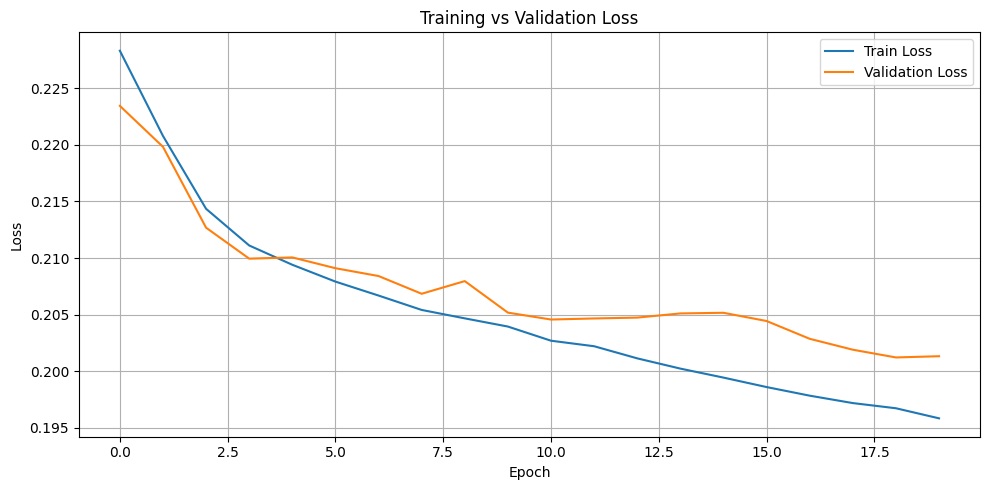

In [4]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

# 1. Load preprocessed data with engineered features already in it
df = pd.read_csv("./DATA/data1day.csv")
df['HOUR_TIME'] = pd.to_datetime(df['HOUR_TIME'])

# 2. Create classification label
df['performance_issue'] = (df['AVG_PROCESSING_TIME_MINUTES'] > 10).astype(int)

# 3. Encode CHUTE and ZIP_CODE
df['CHUTE'] = df['CHUTE'].astype('category').cat.codes
df['ZIP_CODE'] = df['ZIP_CODE'].astype('category').cat.codes

# 4. Sort by time
df = df.sort_values(by=['CHUTE', 'ZIP_CODE', 'HOUR_TIME']).reset_index(drop=True)

# 5. Feature list (all already present)
features = [
    'CODS_ZENT_NR', 'CHUTE', 'ZIP_CODE', 'PACKAGE_COUNT',
'CHUTE_LOAD','ZIP_PACKAGE_COUNT','HOUR_OF_DAY','DAY_OF_WEEK'    
]
target_reg = 'AVG_PROCESSING_TIME_MINUTES'
target_cls = 'PERFORMANCE_ISSUE'
missing = [col for col in features if col not in df.columns]
if missing:
    raise ValueError(f"Missing features in input data: {missing}")

# 6. Normalize features and targets
feature_scaler = MinMaxScaler()
df[features] = feature_scaler.fit_transform(df[features])

target_scaler = MinMaxScaler()
df[[target_reg]] = target_scaler.fit_transform(df[[target_reg]])

# 7. Create LSTM input sequences
def create_sequences(data, target_reg_idx, target_cls_idx, seq_len=5):
    X, y_reg, y_cls = [], [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :-2])
        y_reg.append(data[i+seq_len, target_reg_idx])
        y_cls.append(data[i+seq_len, target_cls_idx])
    return np.array(X), np.array(y_reg), np.array(y_cls)

data = df[features + [target_reg, target_cls]].values
X, y_reg, y_cls = create_sequences(data, len(features), len(features)+1)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_reg_tensor = torch.tensor(y_reg, dtype=torch.float32)
y_cls_tensor = torch.tensor(y_cls, dtype=torch.float32)

# 8. Prepare DataLoaders
dataset = TensorDataset(X_tensor, y_reg_tensor, y_cls_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

# 9. Define LSTM hybrid model
class LSTMHybrid(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc_reg = nn.Linear(hidden_size, 1)
        self.fc_cls = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc_reg(out), self.sigmoid(self.fc_cls(out))

model = LSTMHybrid(input_size=X.shape[2])
criterion_reg = nn.MSELoss()
criterion_cls = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 10. Train the model
train_losses, val_losses = [], []
best_val_loss = float("inf")
best_model_state = None

for epoch in range(20):
    model.train()
    train_loss = 0
    for xb, yb_reg, yb_cls in train_loader:
        optimizer.zero_grad()
        out_reg, out_cls = model(xb)
        loss = criterion_reg(out_reg.view(-1), yb_reg) + criterion_cls(out_cls.view(-1), yb_cls)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb_reg, yb_cls in val_loader:
            out_reg, out_cls = model(xb)
            loss = criterion_reg(out_reg.view(-1), yb_reg) + criterion_cls(out_cls.view(-1), yb_cls)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}")

# 11. Save best model
torch.save(best_model_state, "best_lstm_hybrid.pt")
print("✅ Best model saved.")

# 12. Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Add a Function: predict_at_time()

In [5]:
def predict_new_data(new_df, model, feature_scaler, target_scaler, seq_len=5):
    # Preprocess new data
    new_df = new_df.sort_values(by=['CHUTE', 'ZIP_CODE', 'HOUR_TIME']).reset_index(drop=True)
    new_df['HOUR_TIME'] = pd.to_datetime(new_df['HOUR_TIME'])
    new_df['CHUTE'] = new_df['CHUTE'].astype('category').cat.codes
    new_df['ZIP_CODE'] = new_df['ZIP_CODE'].astype('category').cat.codes

    # Recreate features
    new_df['chute_load'] = new_df.groupby(['CHUTE', 'HOUR_TIME'])['PACKAGE_COUNT'].transform('sum')
    new_df['zip_package_count'] = new_df.groupby(['ZIP_CODE', 'HOUR_TIME'])['PACKAGE_COUNT'].transform('sum')
    new_df['hour_of_day'] = new_df['HOUR_TIME'].dt.hour
    new_df['day_of_week'] = new_df['HOUR_TIME'].dt.dayofweek

    # Scale
    new_df[features] = feature_scaler.transform(new_df[features])

    # Create sequences
    data = new_df[features].values
    X_new = [data[i:i+seq_len] for i in range(len(data) - seq_len)]
    X_new_tensor = torch.tensor(np.array(X_new), dtype=torch.float32)

    with torch.no_grad():
        y_pred_reg, y_pred_cls = model(X_new_tensor)
        predicted_time = target_scaler.inverse_transform(y_pred_reg.view(-1).reshape(-1, 1)).flatten()
        predicted_flag = (y_pred_cls.view(-1).numpy() > 0.5).astype(int)

    return pd.DataFrame({
        "Predicted_Processing_Time": predicted_time,
        "Predicted_Performance_Issue": predicted_flag
    })


In [6]:
def predict_at_time(df_raw, target_time, model, feature_scaler, target_scaler, seq_len=5):
    df_raw['HOUR_TIME'] = pd.to_datetime(df_raw['HOUR_TIME'])
    df = df_raw[df_raw['HOUR_TIME'] <= pd.to_datetime(target_time)]
    df = df.sort_values(by='HOUR_TIME').reset_index(drop=True)

    if len(df) < seq_len:
        print("❌ Not enough history before the given time.")
        return None

    seq_df = df.iloc[-seq_len:].copy()
    seq_df['CHUTE'] = seq_df['CHUTE'].astype('category').cat.codes
    seq_df['ZIP_CODE'] = seq_df['ZIP_CODE'].astype('category').cat.codes
    seq_df['chute_load'] = seq_df.groupby(['CHUTE', 'HOUR_TIME'])['PACKAGE_COUNT'].transform('sum')
    seq_df['zip_package_count'] = seq_df.groupby(['ZIP_CODE', 'HOUR_TIME'])['PACKAGE_COUNT'].transform('sum')
    seq_df['hour_of_day'] = seq_df['HOUR_TIME'].dt.hour
    seq_df['day_of_week'] = seq_df['HOUR_TIME'].dt.dayofweek
    seq_df[features] = feature_scaler.transform(seq_df[features])

    x_seq = torch.tensor([seq_df[features].values], dtype=torch.float32)

    with torch.no_grad():
        y_pred_reg, y_pred_cls = model(x_seq)
        predicted_time = target_scaler.inverse_transform(
            y_pred_reg.view(-1).reshape(-1, 1)
        ).flatten()[0]
        predicted_issue = int(y_pred_cls.view(-1).item() > 0.5)

    print(f"📅 Time: {target_time}")
    print(f"⏱️ Predicted Avg Processing Time: {predicted_time:.2f} minutes")
    print(f"🚨 Performance Issue: {'YES' if predicted_issue else 'NO'}")

    return predicted_time, predicted_issue


In [7]:
# Full prediction on a CSV
new_data = pd.read_csv("./DATA/data5day.csv")
results = predict_new_data(new_data, model, feature_scaler, target_scaler)
print(results.head())

# Single point in time
predict_at_time(new_data, "2025-03-21 22:00", model, feature_scaler, target_scaler)


   Predicted_Processing_Time  Predicted_Performance_Issue
0                   2.181135                            0
1                   3.208473                            0
2                   2.331852                            0
3                   3.116791                            0
4                   2.073709                            0
📅 Time: 2025-03-21 22:00
⏱️ Predicted Avg Processing Time: 32.44 minutes
🚨 Performance Issue: YES


C:\Users\mansourmoa\AppData\Local\Temp\ipykernel_3136\4201476660.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  x_seq = torch.tensor([seq_df[features].values], dtype=torch.float32)


(np.float64(32.44290687243143), 1)